# How to Ride the Shopping Cart

## Abstract

Let’s face it: grocery shopping is not a skill most of us intentionally invested effort in pursuing. However, people more than often find themselves in situations where they return home with two bags of groceries and realize that they are missing the only item they initially were out for. Sometimes, not having a clear idea about our inventory state, we end up being tempted into the all sorts of treats that are over and above our necessities. Or we buy products to showcase our cooking abilities for the family dinner but somehow, we end up with the fridge full of everything, hoping to roll up our sleeves tomorrow. We are often surprised by the number of items we throw away because the expiration date passed two months ago! However, that could change...

## Main Research Question

In this notebook we try to address the following research question:

- Interplay between income and expenses?

### Sub-Questions

In particular, we are interested in the following sub-questions:

- How do households choose to organize their limited annual income according to their shopping expenses?

- Can we infer different household types based on the relation between their income and transaction statistics?

- Are some demographic properties of the household's indicators of this relation as well? That is, can we infer common family values indirectly from this data? 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout, Dropdown
from IPython.display import display
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.colors import DEFAULT_PLOTLY_COLORS as colors

sns.set(style='whitegrid')

np.set_printoptions(suppress=True)

In [2]:
DATA_DIR = 'data/'

CAMPAIGN_DESC = 'campaign_desc.csv'
CAMPAIGN_TABLE = 'campaign_table.csv'
CAUSAL_DATA = 'causal_data.csv'
COUPON = 'coupon.csv'
COUPON_REDEMPT = 'coupon_redempt.csv'
HH_DEMOGRAPHIC = 'hh_demographic.csv'
PRODUCT = 'product.csv'
TRANSACTION_DATA = 'transaction_data.csv'

## Part 1: Introduction

There are several factors that contribute to how people spend their annual income:

1. Income category
    - In our dataset we have several categories ranging from below **15,000** to over **250,000 USD p.a.**
2. Shopping behavior
    - It mainly depends on the day of the week
2. Campaigns play a major role
    - Some households take active participation in campaigns which significantly lowers the expenses
3. Products vary in price
    - Some products are much more expensive than others, nonetheless their purchase is unavoidable
4. Households preferences
    - Households with lower income tend to buy low-budget goods, as opposed to households with higher income that buy high-end goods (like organic food)
5. Demographics

To begin answering our question, we first perform data exploration on the **Dunnhumby** dataset to get initial insight for the task.

## Part 2: Preprocessing

### Loading the Data

For this research question, we will mainly work with the `hh_demographic` and `transaction_data` datasets.

In [3]:
# Load the data from hh_demographic.csv
df_hh_demographic = pd.read_csv(DATA_DIR + HH_DEMOGRAPHIC, index_col='household_key')

print('Number of households:', len(df_hh_demographic))

df_hh_demographic.head()

Number of households: 801


,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC
household_key,,,,,,,
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown
7,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown
8,25-34,U,25-34K,Unknown,2 Adults Kids,3,1
13,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2
16,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown


In [4]:
# Load the data from transaction_data.csv
df_transaction_data = pd.read_csv(DATA_DIR + TRANSACTION_DATA)

print('Number of transactions:', len(df_transaction_data))

df_transaction_data.head()

Number of transactions: 2595732


,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


We observe that the `transaction_data` dataset contains a large number (circa 2.5 mil) of transactions. On the other hand, the `hh_demographic` dataset is much smaller in size (801).

Furthermore, there are transactions for which demographic data is not present. The reason behind the missing demographic information are privacy issues (as stated in the documentation).

### Handling Missing and Inconsistent Data

In [5]:
print('Columns with missing values in household dataset:',
      np.any(df_hh_demographic.isna().sum()))

print('Columns with missing values in transactions dataset:',
      np.any(df_transaction_data.isna().sum()))

Columns with missing values in household dataset: False
Columns with missing values in transactions dataset: False


There are none missing values in both datasets.  

However, in the `transaction_data` dataset we observed that some entries contain 0 for `SALES_VALUE` (the total amount received by the retailer) and for `QUANTITY` (the number of products purchased). There may be a valid reason why the data had been recorded this way, however we chose to avoid any assumptions and discard these transactions, as it is only a small percentage of the whole dataset. 

In [6]:
# Store the valid transactions in a new dataframe
c = (df_transaction_data['SALES_VALUE'] != 0) & \
    (df_transaction_data['QUANTITY'] != 0)

df_transaction_data_cleaned = df_transaction_data[c]

print('Number of transactions:', len(df_transaction_data_cleaned))

Number of transactions: 2576815


Furthermore, following the previous discussion about missing demographic information, we filter the data:

In [7]:
# Keep only the transactions of the households for which we have demographic data
c = df_transaction_data_cleaned['household_key'].isin(df_hh_demographic.index)

df_transaction_data_cleaned = df_transaction_data_cleaned[c]

print('Number of transactions:', len(df_transaction_data_cleaned))

Number of transactions: 1416672


The `transaction_data` now is half its size before.

**Note**: Although, technically there are none missing values in both datasets, still, the columns: `MARITAL_STATUS_CODE`, `HOMEOWNER_DESC`, and `KID_CATEGORY_DESC` in the `hh_demographic` dataset, take values `U`, `Unknown`, and `None/Unknown` respectively which are unknown values. However, since the columns are categorical, we treat this values as yet another category with hope that later on we can obtain some useful insights.

### Feature Expansion

Using the formulas given in the dataset documentation, we can compute the values most useful for our analysis.

In [8]:
sales_value = df_transaction_data_cleaned['SALES_VALUE']
coupon_desc = df_transaction_data_cleaned['COUPON_DISC']
retail_disc = df_transaction_data_cleaned['RETAIL_DISC']
coupon_match_disc = df_transaction_data_cleaned['COUPON_MATCH_DISC']
quantity = df_transaction_data_cleaned['QUANTITY']

After reading the dataset documentation, we noted that the price noted in the `SALES_VALUE` column is only the amount of money the retailer i.e. the store received from the customer. However, as we wish to know how much the *customer* spent and how much did the product they bought actually cost, we have to infer this information from the data. Fortunately, in the dataset documents formulas are provided to calculate these quantities.

In the `CUSTOMER_PAID` column we store the amount the customer had to pay, which is the `SALES_VALUE` reduced by the discount amount provided if the customer possessed a coupon from the product manufacturer, stored in the `COUPON_DISC` column.

On the other hand, in the `PRODUCT_PRICE` column we store the actual price of the product, which can be calculated by first re-adding back the discounts provided by the retailer's coupon and loyalty card possession from the manufacturer (the `COUPON_MATCH_DISC` and `RETAIL_DISC` columns) and then just dividing by the product `QUANTITY`. 

In [9]:
# Use the provided formulas to calculate the new features and store them as new columns
df_transaction_data_cleaned['CUSTOMER_PAID'] = sales_value + coupon_desc
df_transaction_data_cleaned['PRODUCT_PRICE'] = (sales_value - (retail_disc + coupon_match_disc)) / quantity

### Type Conversion

In [10]:
income_desc_categories = [
    'Under 15K',
    '15-24K',
    '25-34K',
    '35-49K',
    '50-74K',
    '75-99K',
    '100-124K',
    '125-149K',
    '150-174K',
    '175-199K',
    '200-249K',
    '250K+'
]

# Convert the INCOME_DESC feature column from string type to ordinal (ordered categorical)
df_hh_demographic['INCOME_DESC'] = pd.Categorical(df_hh_demographic['INCOME_DESC'],
                                                  categories=income_desc_categories,
                                                  ordered=True)

We could also typecast the other columns, but for now only `INCOME_DESC` is required to perform the analysis.

### What's in the data?

All the columns in the `hh_demographic` are categorical. On the other hand, the columns in `transaction_data` are numerical. More information regarding the value ranges is given in the readme file.

Lets analyse the two derived columns in `transaction_data`: `CUSTOMER_PAID` and `PRODUCT_PRICE`. All the necessary information about a transaction is captured by these two columns. The other columns have data about the basket, time, product, and the retail store, which are not relevant at this moment.

In [11]:
df_transaction_data_cleaned[['CUSTOMER_PAID','PRODUCT_PRICE']] \
    .describe() \
    .loc[['min', 'max']]

,CUSTOMER_PAID,PRODUCT_PRICE
min,-8.99,0.001759
max,840.00,299.990000


We see that, in certain cases, the buyer didn't have to pay a penny as opposed to cases where the maximum bill amount was as high as \\$840. Also, there is a clear difference between the cheapest and most expensive product bought from the retail store.

Why is the amount paid negative though?

In [12]:
# Retrieve the transactions with negative values for the amount paid by the customer
df_transaction_data_cleaned[df_transaction_data_cleaned['CUSTOMER_PAID'] < 0].head()

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,CUSTOMER_PAID,PRODUCT_PRICE
25640,1228,27399113659,36,840938,1,8.99,406,-1.00,2132,6,-9.99,0.00,-1.00,9.99
25642,1228,27399113659,36,881931,1,3.59,406,-0.40,2132,6,-5.99,0.00,-2.40,3.99
31812,2448,27468900591,41,970714,1,0.99,362,-0.40,1257,7,-1.00,0.00,-0.01,1.39
32186,1928,27469012501,41,1092045,1,0.88,330,-0.31,1823,7,-1.00,0.00,-0.12,1.19
32437,979,27469127989,40,1008677,4,1.21,368,0.00,2121,6,-3.08,-0.39,-1.87,0.40


That's the effect of campaigns! During campaigns, that the stores and their customers participate in, coupons can be used to reduce the amount the customer needed to pay for a product. As these coupons usually have fixed discounts, if the discount awarded is higher that the product price we get negative values when calculating the amount payed by the customer. As this is not what really happened (the customer payed \\$0 instead of receiving money from the store), we clamp these negative values to 0 in order for our subsequent analyses to be correct.

In [13]:
# For all of these transactions, clamp the customer payment amount to 0
df_transaction_data_cleaned.loc[df_transaction_data_cleaned['CUSTOMER_PAID'] < 0, 'CUSTOMER_PAID'] = 0

Let's plot the distributions of `CUSTOMER_PAID` and `PRODUCT_PRICE` (we will work with a sub-sample of 10K elements since the whole dataset contains over 1 million records and it fails to fit the distributions we assume they are following).

In [14]:
def plot_distribution(df, r, column_name):
    '''
    Function to check the distribution of the derived columns
    
    df - dataframe with one column with values of the statistic
    r - right limit value of x-axis 
    column_name - name of the derived column
    '''

    xmin, xmax = 1e-6, r
    lnspc = np.linspace(xmin, xmax, len(df))
    m, s = stats.expon.fit(df)
    pdf_exponential = stats.expon.pdf(lnspc, scale=s)
    a, m, s = stats.powerlaw.fit(df)
    pdf_powerlaw = stats.powerlaw.pdf(lnspc, a, scale=s)

    fig = make_subplots(rows=1,
                        cols=2,
                        subplot_titles=('Linear scale', 'Log scale'))

    fig.add_histogram(x=df,
                      nbinsx=10,
                      hoverinfo='x+y',
                      marker_color=colors[0],
                      row=1,
                      col=1)
    fig.add_scatter(x=lnspc,
                    y=pdf_exponential * len(df),
                    mode='lines',
                    line_color=colors[3],
                    hoverinfo='x+y',
                    row=1,
                    col=1)
    fig.add_scatter(x=lnspc,
                    y=pdf_powerlaw * len(df),
                    mode='lines',
                    line_color=colors[2],
                    hoverinfo='x+y',
                    row=1,
                    col=1)
    fig.update_xaxes(title_text='Value (in $)',
                     range=[xmin, xmax],
                     row=1,
                     col=1)
    fig.update_yaxes(title_text='Total', range=[0, 5000], row=1, col=1)

    fig.add_histogram(x=df,
                      nbinsx=10,
                      hoverinfo='x',
                      marker_color=colors[0],
                      row=1,
                      col=2)
    fig.add_scatter(x=lnspc,
                    y=pdf_exponential * len(df),
                    mode='lines',
                    line_color=colors[3],
                    hoverinfo='x+y',
                    row=1,
                    col=2)
    fig.add_scatter(x=lnspc,
                    y=pdf_powerlaw * len(df),
                    mode='lines',
                    line_color=colors[2],
                    hoverinfo='x+y',
                    row=1,
                    col=2)
    fig.update_xaxes(title_text='Value (in $)',
                     range=[xmin, xmax],
                     row=1,
                     col=2)
    fig.update_yaxes(title_text='Total',
                     range=[0, np.log10(5000)],
                     type='log',
                     row=1,
                     col=2)

    fig.update_layout(showlegend=False,
                      title_text='Distribution of {}'.format(column_name))
    fig.update_layout(height=600)
    fig.show(renderer='iframe_connected')

In [15]:
r = 20
df = df_transaction_data_cleaned['CUSTOMER_PAID'].sample(n=10000, random_state=1)
df = df[(df > 0) & (df < r)] # Remove the outliers

In [16]:
plot_distribution(df, r, 'CUSTOMER_PAID')

In [17]:
r = 20
df = df_transaction_data_cleaned['PRODUCT_PRICE'].sample(n=10000, random_state=1)
df = df[(df > 0) & (df < r)] # Remove the outliers

In [18]:
plot_distribution(df, r, 'PRODUCT_PRICE')

Looks like we have an exponential distribution for both columns.

### Joining Datasets

We join the two datasets to obtain the transactions for each household. 

In [19]:
df_households_transactions = df_transaction_data_cleaned.join(df_hh_demographic, on='household_key')

print('Total number of transactions for the selected households:',
      len(df_households_transactions))

Total number of transactions for the selected households: 1416672


## Part 3: Data Analysis

### Analysis of the Underlying Distributions

The following analysis can help us discover the shopping habits of the households, regardless of their annual income.

#### Household Income

We noted that one of the major factors in determining the household expenses is the household income category. This is represented by the `INCOME_DESC` column. It holds information about the total anual income for each household.

The main challenge in answering our question is the fact that this column is non numeric - each income value is represented as a category which represents an interval of income values. Looking on the bright side, there is meaningful ordering of the categories as they are intervals. 

In [20]:
income_desc = df_hh_demographic['INCOME_DESC'].value_counts().sort_index()
plot_data = income_desc.reset_index().sort_values('index', ascending=False)
plot_data.columns=['Annual income (in $)', 'Number of households']

fig = px.bar(plot_data,
             x='Number of households',
             y='Annual income (in $)',
             color='Number of households',
             color_continuous_scale='greens',
             orientation='h')
fig.update_layout(title_text='Distribution of household income')
fig.update_layout(height=600)
fig.show(renderer='iframe_connected', responsive=True)

While there is nothing wrong with this plot on first sight, careful analysis reveils a large problem with it: The bins are not equidistant. Therefore, it is biased towards bins of larger range. For example, the *15-24K* bin only spans a *9K* income range, while the *200-249K* bin spans a *49K* range. For a fair plot, we need to divide all the bins by their range. That way, we get an approximate *income distribution density* of the number of households per *1K* income range.

In [21]:
# Define the bin ranges for income, list of values in the form [right bin range, left bin range]
bins = np.array([
    [15,0],
    [24,15],
    [34,25],
    [49,35],
    [74,50],
    [99,75],
    [124,100],
    [149,125],
    [174,150],
    [199,175],
    [249,200],
    [350,250]
])

# Calculate the bin sizes (lengths), to be used for normalization
diff = bins[:,0]-bins[:,1]

# Calculate the geometric means of the bins, to be used for fitting a log-normal distribution curve
geo_means = np.sqrt(bins[:,0]*bins[:,1])
geo_means[0] = np.mean([bins[0,0],bins[0,1]])

The `geo_means` variable is relevant, as it approximately represents the average value within every bin (assuming a log-normal distribution). The geometric mean between the lower and upper bound of a bin is more accurate than taking the average between the upper and lower bound. 

In [22]:
# Calculate the income densities by dividing by the bin sizes
income_desc = df_hh_demographic['INCOME_DESC'].value_counts().sort_index()
income_desc_density = (income_desc / diff).values

In [23]:
# Creating samples for the lognormal distribution
accuracy_param = 7 # This parameter is used to create an array which is sampled from the log-normal
samples = [[np.round(geo_mean), ] * int(accuracy_param * density)
           for geo_mean, density in zip(geo_means, income_desc_density)]
samples = [j for sub in samples for j in sub]

In [24]:
from scipy.stats import lognorm
sigma, mu, alpha = lognorm.fit(np.array(samples)/accuracy_param)

In [25]:
plot_data = (income_desc / diff).reset_index().sort_values('index', ascending=False)
plot_data.columns=['Annual income (in $)', 'Density of households']

fig = px.bar(plot_data,
             x='Density of households',
             y='Annual income (in $)',
             color='Density of households',
             color_continuous_scale='greens',
             orientation='h')
fig.update_layout(title_text='Distribution of household income')
fig.update_layout(height=600)
fig.show(renderer='iframe_connected')

Here we can see that the distribution looks like a log-normal distribution, which was to be expected given the Central Limit Theorem for positive values (income can only take values larger than zero, so the distribution has to be log-normal, instead of normal).

In [26]:
import scipy.stats as ss

def plot_f(x_range, mu, sigma, alpha):
    '''
    Plots the f distribution function for a given x range, dfn and dfd
    If mu and sigma are not provided, standard f is plotted
    Passes any keyword arguments to matplotlib plot function
    '''
    x = x_range
    #y = ss.f.pdf(x, dfn, dfd, mu, sigma)
    #y = 1/((x-mu)*np.sqrt(2*np.pi*sigma**2))*np.exp(-np.log((x-mu)/alpha)**2/2/sigma**2)
    y = lognorm.pdf(x, s=sigma, loc=mu, scale=alpha)
    y_scaling = np.max(income_desc_density)/np.max(y)
    
    fig = make_subplots()
    fig.add_scatter(x=x*10, y=y*y_scaling, mode='lines', name='Log-normal fit')
    fig.add_scatter(x=geo_means, y=income_desc_density, mode='markers', name='Geometric means')
    fig.update_xaxes(title_text='Annual income (in thousands of $)',
                     range=[0, 300])
    fig.update_yaxes(title_text='Density of households')

    fig.update_layout(title_text='Lognormal distribution fit of household income')
    fig.update_layout(height=600)
    fig.show(renderer='iframe_connected')

x = np.linspace(0.001, 100, 500)
plot_f(x, mu, sigma, alpha)

#### Average Bill Amount

To measure the spending habits of the households, we compute the average amount of households' bills. Each household visit to a store is uniquely identified with a `BASKET_ID`. We do this in two steps:

1. We sum the derived `CUSTOMER_PAID` column across the transactions for each visit to get the total bill amount for the visit. <br>
2. We average across all visits of each household.

In [27]:
df_households_basket_payment = df_households_transactions \
    .groupby(['household_key', 'BASKET_ID'])['CUSTOMER_PAID'] \
    .sum()

df_households_basket_payment_average = df_households_basket_payment.groupby(['household_key']).mean()

In [28]:
from scipy.stats import iqr
def calculate_bin_size(data):
    '''Function to calculate the appropriate histogram bin size using the Freedman-Diaconis rule'''
    return 2 * iqr(data) / (len(data)**(1 / 3))

In [29]:
hist_data = [list(df_households_basket_payment_average),]
group_labels = [None, ]
fig = ff.create_distplot(hist_data, group_labels, bin_size=calculate_bin_size(hist_data[0]), show_rug=False)
fig.data[0]['hoverinfo'] = 'x+y'
fig.data[1]['hoverinfo'] = 'x+y'
fig.update_layout(title_text='Distribution of average bill amount',
                  xaxis_title='Average bill amount (in $)',
                  yaxis_title='Density of households',
                  showlegend=False)
fig.update_layout(height=600)
fig.show(renderer='iframe_connected')

Looking at the histogram of this statistic, we identify it as a right-skewed Gaussian distribution, with a few outliers.

On average, people spend around \\$30 at a local retailer, which is kind of expected. However, there are several outliers and this is further investigated below.

#### Average Number of Products
To measure the spending habits of the households, we can also compute statistics based on the products. For instance, the simplest idea would be to just count the number of different products bought and average across all visits.

In [30]:
df_household_basket_num_products = df_households_transactions \
                                   .groupby(['household_key', 'BASKET_ID'])['PRODUCT_ID'] \
                                   .count()

df_households_basket_num_products_average = df_household_basket_num_products.groupby('household_key').mean()

In [31]:
hist_data = [list(df_households_basket_num_products_average),]
group_labels = [None, ]
fig = ff.create_distplot(hist_data, group_labels, bin_size=calculate_bin_size(hist_data[0]), show_rug=False)
fig.data[0]['hoverinfo'] = 'x+y'
fig.data[1]['hoverinfo'] = 'x+y'
fig.update_layout(title_text='Distribution of average number of products',
                  xaxis_title='Average number of products',
                  yaxis_title='Density of households',
                  showlegend=False)
fig.update_layout(height=600)
fig.show(renderer='iframe_connected')

Similarly as before, from the histogram we identify this statistic as having a right-skewed Gaussian distribution, with a few outliers.

On average, people buy around 10 products and it is more likely to observe a greater than average number of products bought during a shopping visit than lesser, which is expected - hence the longer right tail.

#### Average Median Product Price

Product prices are more reflective of the expenses that households have, rather than just counting the number of products.

From this perspective, we can calculate a different statistic quantifying the spending habits of each household. This time we use the derived `PRODUCT_PRICE` to calculate the median product price in each basket and then average across for each household.

We calculate this statistic because the median is a good indicator of the households spending habit during a trip. The average, lowest or greatest price of a product in the basket would not be relevant, as they are very sensitive to outliers while the median is a robust statistic.

The reason for the prevalence of outliers in the product prices, stem for the fact that they are the actual value of a single product and do not take into account the product quantity in the bill, unlike the `CUSTOMER_PAID` values.  

In [32]:
df_households_basket_median_product_price = df_households_transactions \
    .groupby(['household_key', 'BASKET_ID'])['PRODUCT_PRICE'] \
    .median()

df_households_basket_median_product_price_average = df_households_basket_median_product_price.groupby('household_key').mean()

In [33]:
hist_data = [list(df_households_basket_median_product_price_average),]
group_labels = [None, ]
fig = ff.create_distplot(hist_data, group_labels, bin_size=calculate_bin_size(hist_data[0]), show_rug=False)
fig.data[0]['hoverinfo'] = 'x+y'
fig.data[1]['hoverinfo'] = 'x+y'
fig.update_layout(title_text='Distribution of average median product price',
                  xaxis_title='Average median product price (in $)',
                  yaxis_title='Density of households',
                  showlegend=False)
fig.update_layout(height=600)
fig.show(renderer='iframe_connected')

We observe from the histogram that this feature has a bit more regular Gaussian distribution with a mean around \\$2\.50. However, there are also outliers in this statistic. This is depicted in detail in another study below.

### Statistics Comparison

#### Correlation

We are interested in whether these exist any correlation between these three statistics. Does the median product price determine the actual value on the bill?

Using a scatter plot, we would like to confirm (or deny) this.

In [34]:
# Compute the Spearman correlation coefficient between the two statistics
spearman_corr_coef = df_households_basket_payment_average.corr(df_households_basket_median_product_price_average,
                                                               method='spearman')
print('Correlation coefficient:', spearman_corr_coef)

plot_data = pd.concat((df_households_basket_payment_average, df_households_basket_median_product_price_average), axis=1)
plot_data.columns = ['Average bill amount (in $)', 'Average median product price (in $)']

fig = px.scatter(data_frame=plot_data,
                 x='Average bill amount (in $)',
                 y='Average median product price (in $)',
                 trendline='ols')
fig.update_layout(title_text='Correlation between the two statistics')
fig.update_layout(height=600)
fig.show(renderer='iframe_connected')

Correlation coefficient: 0.18890914100516498


Interestingly, we observe almost no correlation between these two statistics! This would mean that the representative price of the products in the basket is very unrelated to the actual amount payed at the register. As such, these two features measure two very different aspects of a household's spending habits and must be used together as a pair to describe a household.

In [35]:
# Compute the Spearman correlation coefficient between the two statistics
spearman_corr_coef = df_households_basket_num_products_average.corr(df_households_basket_payment_average,
                                                               method='spearman')
print('Correlation coefficient:', spearman_corr_coef)

plot_data = pd.concat((df_households_basket_num_products_average, df_households_basket_payment_average), axis=1)
plot_data.columns = ['Average number of products', 'Average bill amount (in $)']

fig = px.scatter(plot_data,
                 x='Average number of products',
                 y='Average bill amount (in $)',
                 trendline='ols')
fig.update_layout(title_text='Correlation between the two statistics')
fig.update_layout(height=600)
fig.show(renderer='iframe_connected')

Correlation coefficient: 0.9079176919106191


Unlike the previous pair, the mean number of products and the average bill amounts seem to be almost perfectly correlated! This was expected however: as you buy more products the more will the bill amount increase. As this statistic is not a good descriptor anyway, we have proved that we can discard it as it does not bring new information.

In [36]:
# Compute the Spearman correlation coefficient between the two statistics
spearman_corr_coef = df_households_basket_num_products_average.corr(df_households_basket_median_product_price_average,
                                                                    method='spearman')
print('Correlation coefficient:', spearman_corr_coef)

plot_data = pd.concat((df_households_basket_num_products_average,
                       df_households_basket_median_product_price_average),
                      axis=1)
plot_data.columns = [
    'Average number of products', 'Average median product price (in $)'
]

fig = px.scatter(plot_data,
                 x='Average number of products',
                 y='Average median product price (in $)',
                 trendline='ols')
fig.update_layout(title_text='Correlation between the two statistics')
fig.update_layout(height=600)
fig.show(renderer='iframe_connected')

Correlation coefficient: 0.04192532577557339


We observe that the average number of products is uncorrelated also with the average median product price. This is expected as it follows from the other two results. So we have two pairs of uncorrelated statistics, however as the average bill amount is obviously more expressive than the number of products, the final decision is definitely to discard the latter.

### Analysis of the Joint Distribution 

Now that we have insight on how much money, on average, people spend on each visit to the store and how does the representative product price bought vary, we are interested to see does the household income play a crucial role in this. Our expectation is that it does, and that households with lower income spend less and buy cheaper products as opposed to households with higher income.

#### Household Income vs. Average Bill Amount

Using a boxplot we can view the distribution of the statistic across each household income category and perform a comparison very efficiently.

In [37]:
# Combine the income values and average bill amount values for each household in a new dataframe
df = df_hh_demographic[['INCOME_DESC']].join(df_households_basket_payment_average)

In [38]:
plot_data = df[['CUSTOMER_PAID', 'INCOME_DESC']]
plot_data.columns = ['Average bill amount (in $)', 'Annual income (in $)']

fig = px.box(data_frame=plot_data,
             x='Average bill amount (in $)',
             y='Annual income (in $)',
             orientation='h')
fig.update_layout(
    title_text=
    'Distribution of average bill amount across different income categories',
    yaxis_categoryorder='array',
    yaxis_categoryarray=income_desc_categories,
    yaxis_autorange='reversed')
fig.update_layout(height=600)
fig.show(renderer='iframe_connected')

To our surprise, extreme spending are mostly observed for medium and lower income households.

Using a 2D histogram i.e. heatmap we can compare the relationship between income and the statistic in more detail by viewing their joint distribution.

In [39]:
# Convert the income column from ordinal to string type (needed for plotting compatibility)
mapping = dict(zip(df['INCOME_DESC'], df['INCOME_DESC'].cat.codes))
df['INCOME_DESC'] = df['INCOME_DESC'] \
    .astype(str) \
    .map(mapping)

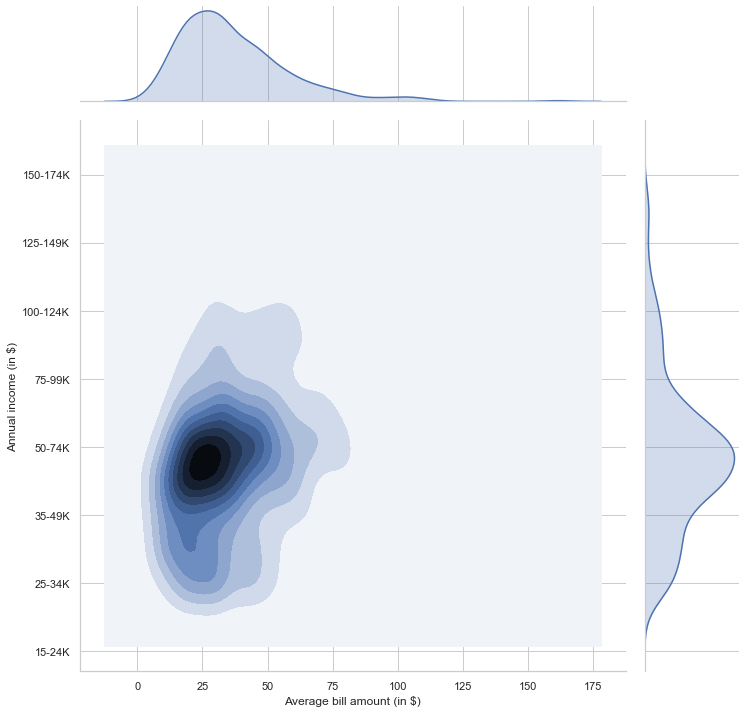

In [40]:
# Use Kernel Density Estimation to estimate the joint distribution from the 2D histogram
g = sns.jointplot(y='INCOME_DESC', x='CUSTOMER_PAID', data=df, kind='kde', height=10)
g.set_axis_labels(
    'Average bill amount (in $)',
    'Annual income (in $)'
)
g.ax_joint.set_yticklabels(income_desc_categories);
plt.savefig("./iframe_figures/figure_40.png", dpi="figure", format="png")

We can observe that the majority of the households are concentrated at the medium income values of 35-74K and lower average expenses of about \\$20 - \\$40.

#### Household Income vs. Average Median Product Price

Similarly, to begin the comparison between household income and median product prices we first merge the two features of each household.

In [41]:
# Combine the income values and average max product price values for each household in a new dataframe
df = df_hh_demographic[['INCOME_DESC']].join(df_households_basket_median_product_price_average)

In [42]:
plot_data = df[['PRODUCT_PRICE', 'INCOME_DESC']]
plot_data.columns = ['Average median product price (in $)', 'Annual income (in $)']

fig = px.box(data_frame=plot_data,
             x='Average median product price (in $)',
             y='Annual income (in $)',
             orientation='h')
fig.update_layout(
    title_text='Distribution of average median product price across different income categories',
    yaxis_categoryorder='array',
    yaxis_categoryarray=income_desc_categories,
    yaxis_autorange='reversed')
fig.update_layout(height=600)
fig.show(renderer='iframe_connected')

The phenomena related to the extreme values is present here as well. Additionally, an interesting difference is the generally smaller value ranges for all of the income categories, capturing the fact that the median has not considered many outlier products with very low or very high prices.

In [43]:
# Convert the income column from ordinal to string type (needed for plotting compatibility)
mapping = dict(zip(df['INCOME_DESC'], df['INCOME_DESC'].cat.codes))

df['INCOME_DESC'] = df['INCOME_DESC'].astype(str).map(mapping)

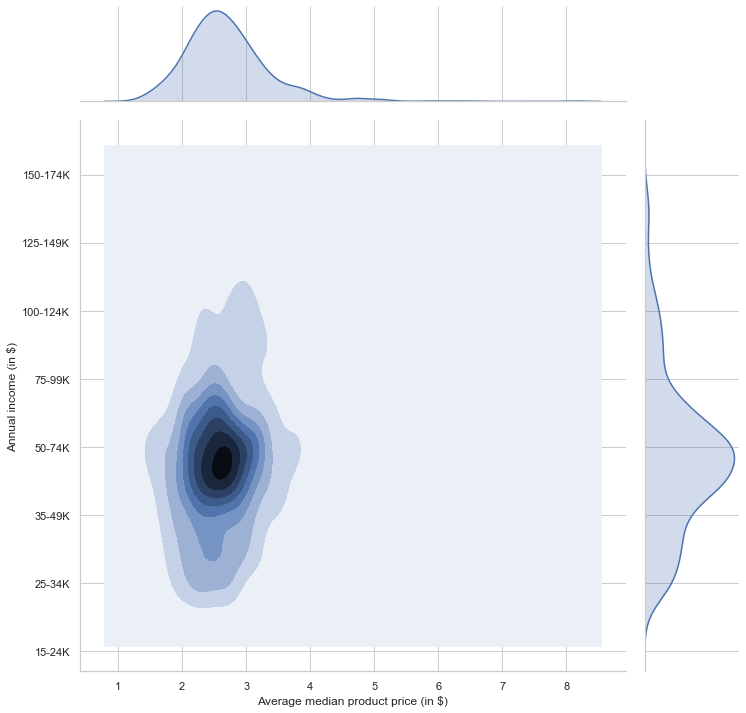

In [44]:
# Use Kernel Density Estimation to estimate the joint distribution from the 2D histogram
g = sns.jointplot(y='INCOME_DESC', x='PRODUCT_PRICE', data=df, kind='kde', height=10)
g.set_axis_labels(
    'Average median product price (in $)',
    'Annual income (in $)'
)
g.ax_joint.set_yticklabels(income_desc_categories);
plt.savefig("./iframe_figures/figure_44.png", dpi="figure", format="png")

Analyzing the joint distribution, we observe that it is similar in form to the one for the previous statistic, although more narrow in the x direction - due to the smaller value ranges of the median as also previously seen with the boxplot. We observe that the most common occurrence is a household with income in the range 50-74K to have an average median product price of about 2\.5$.

### Trends

#### Coupon usage

We noticed that campaigns play a major role in how people spend their money. In deriving the true amount of money that households spend on every visit to the store, we took into account the coupon value. But what is the total amount used and does it vary with the income category?

Coupon value is negative, since it gives a discount to the price. On this bar plot, we see a somewhat unexpected trend. People with medium to upper medium income use more coupons as opposed to the people with lower income. Interesting sight is that people with high income are also heavy users of coupons.

In [45]:
# For each household income category calculate the total coupon discount amount used
# and normalize it by dividing it with the number of households in that category
plot_data = df_households_transactions.groupby(['INCOME_DESC'], observed=True)['COUPON_DISC'] \
    .sum() \
    .div(df_hh_demographic['INCOME_DESC'].value_counts()) \
    .reset_index()
plot_data.columns = ['Annual income (in $)', 'Average total coupon discount amount (in $)']

fig = px.bar(data_frame=plot_data,
             x='Average total coupon discount amount (in $)',
             y='Annual income (in $)',
             orientation='h',
             color = 'Average total coupon discount amount (in $)',
             color_continuous_scale='reds')
fig.data[0]['marker']['color'] *= -1
fig.update_layout(
    title_text='Coupon usage',
    yaxis_categoryorder='array',
    yaxis_categoryarray=income_desc_categories,
    yaxis_autorange='reversed')
fig.update_layout(height=600)
fig.show(renderer='iframe_connected')

#### Daily Expenses

Interesting information can be found by looking into the day of the week when purchases have been made. While we don't know the exact date (and thereby day of the week) from when the data was recorded, it is enough to group the transactions by the *day number* module *7*, in order to plot the transactions throughout an average week. 

In [46]:
df = df_households_transactions.copy()

# Map the integer DAY values(1-711) to weekdays (0-6) using modulo 7
df['DAY'] = df['DAY'].apply(lambda d: d % 7)

# Calculate average customer payments for each weekday
df = df.groupby(['DAY'])['CUSTOMER_PAID'] \
    .sum() \
    .reset_index()

df = df['CUSTOMER_PAID'] / len(df_hh_demographic)

In [47]:
plot_data = df.reset_index()
plot_data.columns = ['Day', 'Total bill amount (in $)']

fig = px.bar(plot_data,
             x='Day',
             y='Total bill amount (in $)',
             color='Total bill amount (in $)',
             color_continuous_scale='blues')
fig.update_layout(title_text="Distribution of bill amount across days of the week")
fig.update_layout(height=600)
fig.show(renderer='iframe_connected')

While we cannot be certain about which day this weeks starts with, it is to be assumed that that the two days with a larger amount of transactions are either Friday and Saturday or Saturday and Sunday. If the data is from the US, it is likely that most purchases have been made on Sunday, as people tend to have more time for shopping, and the stores are usually open on Sunday. We contacted the company which provides this dataset for more information about such details, and are currently waiting for a response. 

#### Mapping Between Expenses and Product Categories

Here we are interested to find out how household expenditure depends on the goods and/or services and how does it vary with household income. For this analysis, we will load the `product.csv` dataset. It contains information about a particular product associated with a transaction.

In [48]:
# Load the data from products.csv
df_product = pd.read_csv(DATA_DIR + PRODUCT, index_col='PRODUCT_ID')

print('Number of products:', len(df_product))

df_product.head()

Number of products: 92353


,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
PRODUCT_ID,,,,,,
25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [49]:
print('Columns with missing values in products dataset:',
      np.any(df_product.isna().sum()))

Columns with missing values in products dataset: False


Although, there are no missing values, the `CURR_SIZE_OF_PRODUCT` column has empty string values. As this is not crutial for our analysis, we are not going to further address this issue. 

We join the household transactions dataset with the products dataset using the `PRODUCT_ID` column.

In [50]:
df_transactions_products = \
    df_households_transactions[['PRODUCT_ID', 'QUANTITY', 'CUSTOMER_PAID', 'INCOME_DESC']] \
    .join(df_product[['COMMODITY_DESC', 'SUB_COMMODITY_DESC']], on='PRODUCT_ID')

df_transactions_products.head()

,PRODUCT_ID,QUANTITY,CUSTOMER_PAID,INCOME_DESC,COMMODITY_DESC,SUB_COMMODITY_DESC
11,842930,1,2.19,100-124K,CONVENIENT BRKFST/WHLSM SNACKS,GRANOLA BARS
12,897044,1,2.99,100-124K,CRACKERS/MISC BKD FD,SNACK CRACKERS
13,920955,1,3.09,100-124K,BEEF,GRND/PATTY - ROUND
14,937406,1,2.50,100-124K,BREAKFAST SAUSAGE/SANDWICHES,LINKS - RAW
15,981760,1,0.60,100-124K,EGGS,EGGS - X-LARGE


The following dataset is just an aggregate over `INCOME_DESC` and `COMMODITY_DESC`. It is usefull for our analysis that follow.

In [51]:
df = df_transactions_products \
    .groupby(['INCOME_DESC', 'SUB_COMMODITY_DESC'], observed=True)['CUSTOMER_PAID'] \
    .sum() \
    .dropna() \
    .to_frame()

df.head()

CUSTOMER_PAID
INCOME_DESC SUB_COMMODITY_DESC                  
Under 15K   *BOYS/GIRLS MISC TOYS           9.99
            *SCRAPBOOK                      3.49
            *SPORT NOVELTIES                2.99
            *SPRING/SUMMER MISC             2.00
            ABRASIVES                      36.96

#### Most Purchased Product

We are interested to see on which product does the households spend most of their money on. This is also dependent on the income category.

In [52]:
# Calculate most purchased product as argmax of total customer payments for each income category
df.unstack().idxmax(axis=1)

INCOME_DESC
Under 15K    (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
15-24K       (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
25-34K       (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
35-49K       (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
50-74K       (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
75-99K       (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
100-124K     (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
125-149K     (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
150-174K     (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
175-199K     (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
200-249K     (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
250K+        (CUSTOMER_PAID, GASOLINE-REG UNLEADED)
dtype: object

It looks like they spend most of their anual income on gasoline, which is expected taking into account the demographics data of the households. But lets see the distribution.

In [53]:
# Calculate the total money spent od unleaded gasoline for each income category
# and normalize with the number of households in each category
stats = df.unstack()['CUSTOMER_PAID']['GASOLINE-REG UNLEADED'] \
    .div(df_hh_demographic['INCOME_DESC'].value_counts().values) \
    .values

stats

array([ 143.42822917,  123.37703488,  293.16083333,  892.79519481,
       1392.28081081,  842.9404918 ,  670.58394737,  924.67705882,
        842.97866667,  738.80818182,   50.73272727,  845.314     ])

In [54]:
# Construct data into the form needed for polar coordinate plotting
# Discrete angle values represent income categories, radius represents normalized gasoline purchases
angles = np.linspace(0, 360, len(income_desc_categories), endpoint=False)
r = np.concatenate((stats, [stats[0]]))
theta = np.concatenate((angles, [angles[0]]))

plot_data = pd.concat(
    (pd.Series(r, name='Normalized gasoline purchases (in $)'),
     pd.Series(income_desc_categories + [income_desc_categories[0],],
               name='Annual income (in $)')),
    axis=1)

fig = px.scatter_polar(plot_data,
                    r='Normalized gasoline purchases (in $)',
                    theta='Annual income (in $)',
                    start_angle=0,
                    direction='counterclockwise',
                    title='Most purchased product category per income')

fig.update_traces(fill='toself', hoveron='points', mode='markers+lines')
fig.update_layout(height=600)
fig.show(renderer='iframe_connected')

The distribution is highly concentrated around the middle to upper middle income categories. The reason is that households with lower income can't afford owning a vehicle, however the reason for the upper income is somewhat unclear. It could be that they use other means of transportation required by their job.

Setting gasoline aside, we are also interest in how the expenses are distributed in the other product categories.

In [55]:
# Temporarily remove all purchase data about this gasoline category
dff = df[df.index.get_level_values('SUB_COMMODITY_DESC') != 'GASOLINE-REG UNLEADED']

dff.head()

CUSTOMER_PAID
INCOME_DESC SUB_COMMODITY_DESC                  
Under 15K   *BOYS/GIRLS MISC TOYS           9.99
            *SCRAPBOOK                      3.49
            *SPORT NOVELTIES                2.99
            *SPRING/SUMMER MISC             2.00
            ABRASIVES                      36.96

For this, we will use a sankey plot because it is an excellent way to visualize flow of information between two subsets. From it, we will have a clear idea about how the expenses from income groups map to product categories.

We will use top 200 products ordered by `QUANTITY` plot the flow diagram between the income and the product category. We can easily visualize how the quantity of the purchased products is distributed and later search for patterns in the expenditure.

In [56]:
# For each income category find the top 15 purchased product categories based on customer spending
dff = dff \
    .reset_index() \
    .groupby(['INCOME_DESC'], observed=True)['SUB_COMMODITY_DESC', 'CUSTOMER_PAID'] \
    .apply(lambda df: df.sort_values(by='CUSTOMER_PAID', ascending=False).head(15)) \
    .reset_index(level=0)

dff

,INCOME_DESC,SUB_COMMODITY_DESC,CUSTOMER_PAID
1466,Under 15K,SOFT DRINKS 12/18&15PK CAN CAR,8161.77
562,Under 15K,FLUID MILK WHITE ONLY,5937.73
327,Under 15K,CIGARETTES,4630.39
319,Under 15K,CHOICE BEEF,4218.34
142,Under 15K,BEERALEMALT LIQUORS,3793.83
...,...,...,...
18110,250K+,ALL FAMILY CEREAL,975.26
18599,250K+,FRZN BAGGED VEGETABLES - PLAIN,960.68
18738,250K+,ISOTONIC DRINKS MULTI-SERVE,926.58
19386,250K+,TOILET TISSUE,865.56


In [57]:
# Aggregate customer payment data first on income categories and then with product categories
# Construct data into form required for the Sankey plot
data = []

palette = sns.color_palette('cubehelix', len(dff) + dff['INCOME_DESC'].nunique())
colours = palette.as_hex()

level1 = dff[['INCOME_DESC', 'CUSTOMER_PAID']] \
    .groupby('INCOME_DESC', observed=True) \
    .agg('sum')

c_count = 0

for i, r in level1.reset_index().iterrows():
    data.append({
        'source': 'Expenditure',
        'target': r['INCOME_DESC'],
        'value': r['CUSTOMER_PAID'],
        'color': colours[c_count]
    })
    
    item_dff = dff[dff['INCOME_DESC'] == r['INCOME_DESC']] \
        [['INCOME_DESC', 'SUB_COMMODITY_DESC', 'CUSTOMER_PAID']] \
        .groupby(['INCOME_DESC', 'SUB_COMMODITY_DESC'], observed=True) \
        .agg('sum') \
        .reset_index()
    
    for item_i, item_r in item_dff.iterrows():
        
        c_count += 1

        data.append({
            'source': item_r['INCOME_DESC'],
            'target': item_r['SUB_COMMODITY_DESC'],
            'value': item_r['CUSTOMER_PAID'],
            'color': colours[c_count]
        })

In [58]:
# Load the sankey plot instead!
#
# w = SankeyWidget(layout=Layout(width='1600', height='3000'),
#                  links=data,
#                  margins=dict(top=0, bottom=0, left=100, right=150))
#
# w.save_png('sankey.png')
#
# w

<img src='sankey.png' />

In order to analyze this sankey diagram further, we call on a principle from microeconomics, called **Engel curves**.

#### Engel curves

One particular way of determining how household expenditure, on a particular good or service, varies with household income is visualizing Engel curves. Engel curves on the x-axis have the income category and on the y-axis the quantity of the measured product. We can infer some type of goods using these curves.

In [59]:
# Calculate total quantity of each product category purchased, for each income category 
df = df_transactions_products \
    .groupby(['INCOME_DESC', 'COMMODITY_DESC'], observed=True)['QUANTITY'] \
    .sum() \
    .dropna() \
    .reset_index(level=1)

For a start, here are the 10 most purchased items:

In [60]:
df.groupby('COMMODITY_DESC')['COMMODITY_DESC','QUANTITY'].sum().sort_values('QUANTITY',ascending=False).head(10)

,QUANTITY
COMMODITY_DESC,
COUPON/MISC ITEMS,162074939
SOFT DRINKS,83045
FLUID MILK PRODUCTS,63882
BAKED BREAD/BUNS/ROLLS,52748
CHEESE,52512
SOUP,46641
YOGURT,45427
VEGETABLES - SHELF STABLE,44723
BAG SNACKS,43184


In [61]:
# commodity_desc_list = df['COMMODITY_DESC'].unique()
commodity_desc_list = [
    'MARGARINES', 'FROZEN', 'PREPARED FOOD', 'PNT BTR/JELLY/JAMS',
    'IMPORTED WINE', 'VEAL']
plot_data = pd.DataFrame()
for commodity_desc in commodity_desc_list:
    df_commodity = df[df['COMMODITY_DESC'] == commodity_desc] \
        .reindex(income_desc_categories, fill_value=0)
    df_commodity['COMMODITY_DESC'] = commodity_desc
    # Calculate the distribution of the average purchased quantity of the product category
    # Normalize with respect to the number of households in each income category 
    df_commodity['QUANTITY'] = df_commodity['QUANTITY'] \
        .div(df_hh_demographic['INCOME_DESC'].value_counts().values)
    # Normalize with respect to the total quantity
    df_commodity['QUANTITY'] = df_commodity['QUANTITY'].div(df_commodity['QUANTITY'].sum())
    plot_data = pd.concat((plot_data, df_commodity.reset_index()))

# Remove the first and last income category because
# they contain all the outliers
plot_data = plot_data[~plot_data['INCOME_DESC'].isin(['Under 15K', '250K+'])]
plot_data.columns = ['Annual income (in $)', 'Product category', 'Quantity']
fig = px.line(plot_data, x='Annual income (in $)', y='Quantity', color='Product category')
fig.update_traces(mode='markers+lines')

menu_buttons = [{'label':'ALL', 'method':'update', 'args':[{'visible':[True,] * len(commodity_desc_list)}]}]
for i, commodity_desc in enumerate(commodity_desc_list):
    button_arg_visible = [False, ] * len(commodity_desc_list)
    button_arg_visible[i] = True
    button = {'label':commodity_desc, 'method':'update', 'args':[{'visible':button_arg_visible}, ]}
    menu_buttons.append(button)
    
dropdown_menu = go.layout.Updatemenu(active=0, buttons=menu_buttons, showactive=True, xanchor="left", x=0.125, yanchor="top", y=1.125)
fig.update_layout(title_text = 'Engel curves', updatemenus = [dropdown_menu, ], showlegend=False)
fig.update_layout(height=600)
fig.show(renderer='iframe_connected')

Here we showcase an example of inferior goods. Margarine is an inferior good since its demand drops when people's incomes rise. This occurs when a good has more costly substitutes (butter) that see an increase in demand as incomes and the economy improve. There are other examples in our dataset (ex. frozen food, prepared food, peanut butter and jelly).

When looking at the above plots, one might be surprised that for all four products, households with low incomes, and households with extremely high income tend to purchase fewer of them. For households with low income, this is no surprise. But what about high-income households? It is likely that individuals of high incomes often dine out, as this saves time. That way, they don't have to purchase large quantities of any products in supermarkets. 

### Demographic Analysis of Household Groups

In order to understand how family values influence the balance between household's expenses and income, we will analyze the demographic properties across 4 groups of households.

In [62]:
# Median values for income and expenses
# We will use the average bill amount statistic to represent expenses
AVG_INCOME = '50-74K'
AVG_EXPENSES = df_households_basket_payment_average.median()

In [63]:
# Split the household demographic dataset into 4 subsets based on income and expenses
df = df_hh_demographic.join(df_households_basket_payment_average.to_frame().rename(columns={'CUSTOMER_PAID': 'EXPENSES'}))

df_low_income_low_expenses = df[(df['INCOME_DESC'] <= AVG_INCOME) & (df['EXPENSES'] <= AVG_EXPENSES)]
df_low_income_high_expenses = df[(df['INCOME_DESC'] <= AVG_INCOME) & (df['EXPENSES'] > AVG_EXPENSES)]
df_high_income_low_expenses = df[(df['INCOME_DESC'] > AVG_INCOME) & (df['EXPENSES'] <= AVG_EXPENSES)]
df_high_income_high_expenses = df[(df['INCOME_DESC'] > AVG_INCOME) & (df['EXPENSES'] > AVG_EXPENSES)]

In [64]:
print('Percent of households with low income and low expenses:', round(len(df_low_income_low_expenses) / len(df_hh_demographic), 4))
print('Percent of households with low income and high expenses:', round(len(df_low_income_high_expenses) / len(df_hh_demographic), 4))
print('Percent of households with high income and low expenses:', round(len(df_high_income_low_expenses) / len(df_hh_demographic), 4))
print('Percent of households with high income and high expenses:', round(len(df_high_income_high_expenses) / len(df_hh_demographic), 4))

Percent of households with low income and low expenses: 0.4082
Percent of households with low income and high expenses: 0.3109
Percent of households with high income and low expenses: 0.0924
Percent of households with high income and high expenses: 0.1885


These groups were generated using the average income and average expenses. We split the households into: below (or above) average income and below (or above) average expenses.

In [65]:
demographic_features = df_hh_demographic.columns.drop('INCOME_DESC')

demographic_features_categories = dict.fromkeys(demographic_features)
demographic_features_categories['AGE_DESC'] = ['19-24', '25-34', '35-44', '45-54', '55-64', '65+']
demographic_features_categories['MARITAL_STATUS_CODE'] = ['A', 'B', 'U']
demographic_features_categories['HOMEOWNER_DESC'] = ['Homeowner', 'Probable Owner', 'Renter', 'Probable Renter', 'Unknown']
demographic_features_categories['HH_COMP_DESC'] = ['2 Adults Kids', '1 Adult Kids', '2 Adults No Kids', 'Single Female', 'Single Male', 'Unknown']
demographic_features_categories['HOUSEHOLD_SIZE_DESC'] = ['1', '2', '3', '4', '5+']
demographic_features_categories['KID_CATEGORY_DESC']= ['None/Unknown', '1', '2', '3+']

demographic_features_clean_names = {'AGE_DESC': 'Age',
                                    'MARITAL_STATUS_CODE': 'Marital Status',
                                    'HOMEOWNER_DESC': 'Homeowner Type',
                                    'HH_COMP_DESC':'Household Composition',
                                    'HOUSEHOLD_SIZE_DESC':'Household Size',
                                    'KID_CATEGORY_DESC':'Number of children'}

plot_data = dict.fromkeys(demographic_features)
for demographic_feature in demographic_features:
    df = pd.concat([
        df_low_income_low_expenses[demographic_feature].value_counts().rename('Low/ Low') / len(df_low_income_low_expenses),
        df_low_income_high_expenses[demographic_feature].value_counts().rename('Low/ High') / len(df_low_income_high_expenses),
        df_high_income_low_expenses[demographic_feature].value_counts().rename('High/ Low') / len(df_high_income_low_expenses),
        df_high_income_high_expenses[demographic_feature].value_counts().rename('High/ High') / len(df_high_income_high_expenses)
    ], axis=1, sort=False)
    df.index = demographic_features_categories[demographic_feature]
    df = df.unstack().reset_index()
    df.columns = ['Income vs. Expenses', demographic_feature, 'Percentage of households']
    plot_data[demographic_feature] = df

def plot_demographic(demographic_feature):
    fig = px.bar(data_frame=plot_data[demographic_feature],
             y='Percentage of households',
             color='Income vs. Expenses',
             barmode='group')
    fig.update_layout(xaxis_title=demographic_features_clean_names[demographic_feature],
                      xaxis_tickmode='array',
                      xaxis_tickvals=list(range(len(demographic_features_categories))),
                      xaxis_ticktext=demographic_features_categories[demographic_feature])
    fig.update_layout(height=600)
    fig.show(renderer='iframe_connected')

#### Age

In [66]:
plot_demographic('AGE_DESC')

From the age distribution of the household groups, we can make a few interesting observations. Among the households with the youngest members there is not a lot of variety in the income-expenses balance. Among the households with members of younger working ages high expenses seem to dominate. As we move to the households with older members lower expenses are more prevalent.

#### Marital Status

In [67]:
plot_demographic('MARITAL_STATUS_CODE')

For clarification, according to the dataset documentation the marital status codes `A`, `B`, and `U` stand for `Married`, `Single` and `Unknown` respectively. Interestingly, this plot efficiently captures classical differences between married and single life, as we observe that **households with married members have more often lower income and must balance with lower expenses**, while it is completely opposite for **single member households, as they more frequently have higher income and are able to indulge in higher expenses**.  

#### Homeowner Type

In [68]:
plot_demographic('HOMEOWNER_DESC')

Analyzing the distribution of the type of homeownership we again obtain expected results, as it is understandable that it is most probable for households who are able to afford their own place of residence to have higher income and expenses, while renters usually have better sense of utilizing their limited income. 

#### Household Composition

In [69]:
plot_demographic('HH_COMP_DESC')

Among the different household compositions recorded in the data, we do not observe a lot of variety and this feature is not a good discriminator. However, we do observe two interesting discrepancies which can also be expected: couples with no children have the highest chance to be in the group with the highest income and expenses, while single parents tend to have a 'harder time'.

#### Household Size

In [70]:
plot_demographic('HOUSEHOLD_SIZE_DESC')

The household size feature also displays very little significance for group distinction across different values. However, we can observe a trend that as the household size increases the probability of having lower income and expenses decreases, as only households with higher income can afford to have more children, but with that their expenses also increase.

#### Number of Children

In [71]:
plot_demographic('KID_CATEGORY_DESC')

The demographic records for the number of children can be inferred from previous features such as household size and household composition and as such in the plot we observe a similar trend as in the previous analysis of household size.

## Part 4: Applied ML

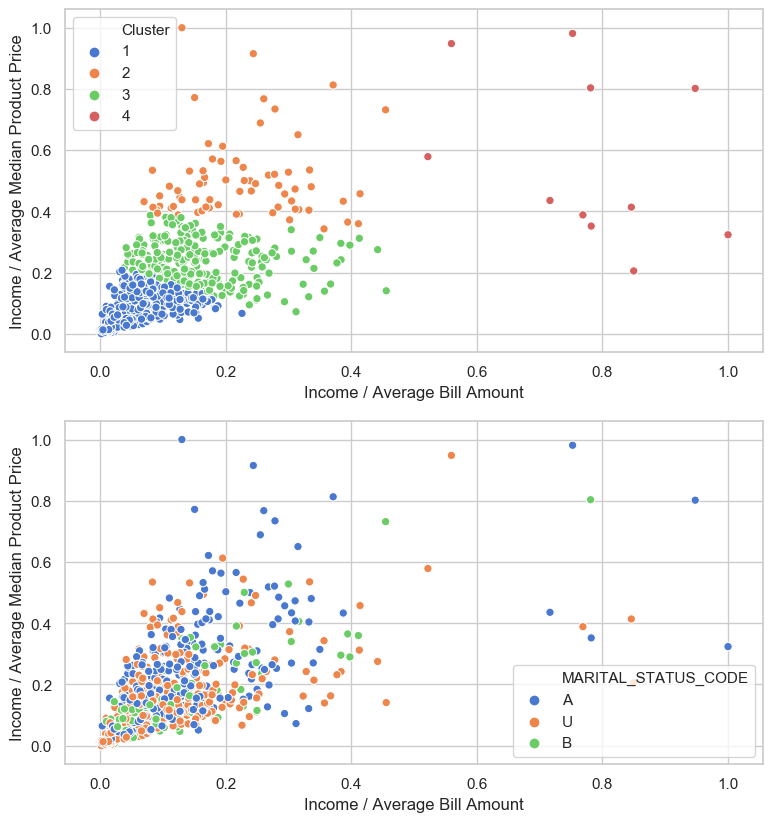

In [72]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# Map income categories to their geometric means of the bins
geo_means = pd.Series(data=geo_means,
                      index=income_desc.index,
                      name='INCOME_DESC_GEO_MEANS')
income_desc_geo_means = df_hh_demographic['INCOME_DESC'].apply(lambda x: geo_means[x]).astype('float')

# Calculate income / expenses ratios
feature_income_and_average_bill_amount = income_desc_geo_means / df_households_basket_payment_average
feature_income_and_average_median_product_price = income_desc_geo_means / df_households_basket_median_product_price_average
X = pd.concat((feature_income_and_average_bill_amount,
               feature_income_and_average_median_product_price),
              axis=1)

# Normalize the features to [0, 1]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X,
                 columns=['Income / Average Bill Amount', 'Income / Average Median Product Price'])

# Cluster the 2D data using K-means
k = 4
kmeans = KMeans(n_clusters=k).fit(X)
labels = pd.Series(kmeans.labels_ + 1, name='Cluster')
X_labeled = pd.concat((X, labels, df_hh_demographic['MARITAL_STATUS_CODE'].reset_index(drop=True)), axis=1)


f, ax = plt.subplots(2, 1, figsize=(9, 2*5), dpi=100)
sns.scatterplot(x='Income / Average Bill Amount',
                y='Income / Average Median Product Price',
                hue='Cluster',
                data=X_labeled,
                palette=sns.color_palette('muted', n_colors=k),
                ax=ax[0])
sns.scatterplot(x='Income / Average Bill Amount',
                y='Income / Average Median Product Price',
                hue='MARITAL_STATUS_CODE',
                data=X_labeled,
                palette=sns.color_palette('muted', n_colors=3),
                ax=ax[1])
plt.show()

We are interested in whether there is a existence of clusters in the set of households, based on income and expenses. We calculate the ratios between a household's income and it's values of the two expenses statistics in order to represent each household with two features in 2D space. These ratios were chosen because they efficiently model the income vs. expenses relationship: they are small if a household has lower income but higher expenses and they are large if a household has higher income but lower expenses. After we perform K-means clustering on these two features however, unfortunately there seems to be no link between the cluster assignment and any demographic feature, as demonstrated with the marital status in the above plot. 

## Part 5: Recap

In this milestone we managed to investigate the data, check for missing values and inconsistencies, do feature expansion, and identify the distribution of the most expressive columns. Furthermore, we analysed the household income categories, how much money households spend on average and by how much is that ammount defined by the products price. Additionaly, we saw the coupon usages among income categories, and looked for trends in daily expenses. Likewise, we investigated how the expenditure is distributed amongst goods and whether households prefer some products over others. Finaly, we did extensive demographic analysis and searched for clusters in the data.